## Data processing 

In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# columns
c_year = 'year'
c_district = 'District'
c_amount = 'Amount in USD (nominal)'
c_country = 'Financier Country'
c_population = 'Population (in 1000)'
c_aid_pc = 'Aid per capita'
c_gov_spend = 'Government Expenditure by district in thousands (year 2013)'
c_gov_spend_pc = 'Government Spending per Capita in thousands (year 2013)'
c_cum_vic = 'Cumulative Victory Margin (average)'
c_gdp = 'GDP (Value Added) Rs. in million (2013)'
c_gdp_usd = 'GDP USD'
c_gdp_usd_pc = 'GDP USD per Capita'
c_hdi = 'HDI (2013)'
c_location = 'Location'
c_ethn = 'Ethnicity'
c_distance_too_long = """Distance to closest border crossing in km (India: Banbasa, India - Kanchanpur District, Nepal;
    Rupaidiha, India - Banke District, Nepal;
    Sonauli, India - Rupandehi District, Nepal;
    Raxaul, India - Birgunj, Nepal (also known as the 'Gateway of Nepal');
    Bhitthamore,India - Mahottari District, Nepal;
    Jogbani, India - Biratnagar, Nepal;
    Panitanki, India - Kakarbhitta, Nepal) (China: Gyirong, China –Rasuwa, Nepal; Zhangmu, China – Kodari, Nepal)"""
c_distance = "Distance to closest border"
c_is_tamang = 'Is tamang?'
c_is_yadav_tharu = 'Is yadav or tharu?'

# values
v_china = 'China (People\'s Republic of)'
v_india = 'India'
v_tamang = 'Tamang'
v_yadav = 'Yadav'
v_tharu = 'Tharu'

# colors
red = '#D32F2F'
green = '#1E8449'

In [669]:
# aid dataset
aid = pd.read_csv('data/aid_projects.csv')
aid[c_year] = aid['Commitment Year']
aid[c_distance] = aid[c_distance_too_long]
aid = aid.drop(['Title', 'Sector Name', 'Funding Agencies', 'Source URLs', 'Commitment Year', c_distance_too_long], axis=1)

# aid data-cleaning
aid[c_distance] = aid[c_distance].str.replace(',', '.')
aid[c_distance] = aid[c_distance].astype(float)

# aid tranformations
aid[c_aid_pc] = aid[c_amount] / aid[c_population]
aid[c_gov_spend_pc] = aid[c_gov_spend] / aid[c_population]
aid[c_gdp_usd] = aid[c_gdp] * 0.0118 * 1e6
aid[c_gdp_usd_pc] = aid[c_gdp_usd] / aid[c_population]
aid[c_is_tamang] = (aid[c_ethn] == v_tamang).astype(int)
aid[c_is_yadav_tharu] = ((aid[c_ethn] == v_yadav) | (aid[c_ethn] == v_tharu)).astype(int)

# aid split
aid_first = aid[aid[c_year] <= 2012]
aid_second = aid[aid[c_year] > 2012]
aid_china = aid[(aid[c_country] == v_china)]
aid_india = aid[(aid[c_country] == v_india)]

In [670]:
# win dataset
win_first = pd.read_csv('data/winning_candidates_2064.csv')
win_second = pd.read_csv('data/winning_candidates_2070.csv')
win_first[c_year] = 2008
win_second[c_year] = 2013
win = pd.concat([win_first, win_second])

# win data cleaning
win[c_cum_vic] = win[c_cum_vic].str.replace(',', '.') 
win[c_cum_vic] = win[c_cum_vic].str.replace('%', '')
win[c_cum_vic] = win[c_cum_vic].astype(float)
win[c_cum_vic] = win[c_cum_vic] / 100

# win split
win_first = win[win[c_year]== 2008]
win_second = win[win[c_year] == 2013]


In [671]:
def get_distr_sum(df: pd.DataFrame, col):
    districts = df[[c_district, col]]
    districts = districts.groupby([c_district]).sum()
    return districts.sort_values(by=col, ascending=False)

def get_distr_mean(df: pd.DataFrame, col):
    districts = df[[c_district, col]]
    districts = districts.groupby([c_district]).mean()
    return districts.sort_values(by=col, ascending=False)

def get_location_sum(df: pd.DataFrame, col):
    locations = df[[c_location, col]]
    locations = locations.groupby([c_location]).sum()
    return locations.sort_values(by=col, ascending=False)

def get_location_mean(df: pd.DataFrame, col):
    locations = df[[c_location, col]]
    locations = locations.groupby([c_location]).mean()
    return locations.sort_values(by=col, ascending=False)



def get_stats(df: pd.DataFrame, col, distr_fun=get_distr_sum, show_split=True):
    distr = distr_fun(df, col)
    
    mean = distr.mean().to_numpy()
    sd = distr.std().to_numpy()
    min = distr.min().to_numpy()
    max = distr.max().to_numpy()
    mean_first = distr_fun(df[df[c_year] <= 2012], col).mean().to_numpy()
    mean_second = distr_fun(df[df[c_year] > 2012], col).mean().to_numpy()
    arr = np.array([mean, sd, min, max, mean_first, mean_second]).flatten()
    if show_split: 
        return arr
    else:
        return arr[:4]

In [672]:
stats_aid_pc = np.log10(get_stats(aid, c_aid_pc)) 

# china
stats_aid_pc_china = np.log10(get_stats(aid_china, c_aid_pc))
aid_china_tamang = aid_china[aid_china[c_ethn] == 'Tamang']
stats_aid_pc_china_tamang = np.log10(get_stats(aid_china_tamang, c_aid_pc))

# india
stats_aid_pc_india = np.log10(get_stats(aid_india, c_aid_pc))
aid_india_tharu_yadav = aid_india[(aid_india[c_ethn] == 'Tharu') | (aid_india[c_ethn] == 'Yadav')]
stats_aid_pc_india_tharu_yadav = np.log10(get_stats(aid_india_tharu_yadav, c_aid_pc))

# Victory margin
stats_cum_vic = get_stats(win.dropna(subset=[c_cum_vic]), c_cum_vic, get_distr_mean)
stats_cum_vic_first = get_stats(win_first.dropna(subset=[c_cum_vic]), c_cum_vic, get_distr_mean, show_split=False)
stats_cum_vic_second = get_stats(win_second.dropna(subset=[c_cum_vic]), c_cum_vic, get_distr_mean, show_split=False)

# projects per district
cheat_aid = aid.copy()
cheat_aid['one'] = 1
cheat_aid_china = cheat_aid[(cheat_aid[c_country] == v_china)]
stats_project_count_china = get_stats(cheat_aid_china, 'one', get_distr_sum)
cheat_aid_india = cheat_aid[(cheat_aid[c_country] == v_india)]
stats_project_count_india = get_stats(cheat_aid_india, 'one', get_distr_sum)

# distance
stats_distance = get_stats(aid, c_distance, get_location_mean, False)
distance_mean = stats_distance[0]
stats_amount_below_distance = np.log10(get_stats(aid[aid[c_distance] <= distance_mean], c_amount, get_location_sum, False))
stats_amount_above_distance = np.log10(get_stats(aid[aid[c_distance] > distance_mean], c_amount, get_location_sum, False))

# other stats
stats_population = np.log10(get_stats(aid, c_population, get_distr_mean, False))
# gov-spend is in thousands, so times 1000
stats_gov_spend_pc = np.log10(get_stats(aid, c_gov_spend_pc, get_distr_mean, False) * 1e3)
stats_gdp = np.log10(get_stats(aid, c_gdp_usd, get_distr_mean, False))
stats_hdi = get_stats(aid, c_hdi, get_distr_mean, False)


In [673]:
stats = pd.DataFrame(
[
    stats_project_count_china,
    stats_project_count_india,
    stats_aid_pc,
    stats_aid_pc_china,
    stats_aid_pc_china_tamang,
    stats_aid_pc_india,
    stats_aid_pc_india_tharu_yadav,
    stats_cum_vic,
    stats_cum_vic_first,
    stats_cum_vic_second,
    stats_distance,
    stats_amount_below_distance,
    stats_amount_above_distance,
    stats_population,
    stats_gov_spend_pc,
    stats_gdp,
    stats_hdi
], 
columns=['Mean', 'SD', 'Min', 'Max', 'Mean First', 'Mean Second'], 
index=[
    'Amount of Projects per District China',
    'Amount of Projects per District India',
    'Aid per Capita (log)', 
    'Chinese Aid per Capita (log)', 
    'Chinese Co-Ethnic District (log)',
    'Indian Aid per Capita (log)', 
    'Indian Co-Ethnic District (log)',
    'Victory Margin', 
    'Victory Margin 2008', 
    'Victory Margin 2013', 
    'Distance to closest border [km]',
    'Aid close to border (log)',
    'Aid far from border (log)',
    'Population (log)', 
    'Government spending per Capita (log)',
    'GDP per district (log)',
    'Human Development Index'
])

stats = stats.round(3)
stats.to_csv('stats_table.csv')
stats

,Mean,SD,Min,Max,Mean First,Mean Second
Amount of Projects per District China,2.556,3.347,1.000,15.000,1.562,3.000
Amount of Projects per District India,7.947,12.664,1.000,55.000,10.727,3.227
Aid per Capita (log),2.578,3.390,-0.794,4.315,1.358,2.563
Chinese Aid per Capita (log),3.189,3.692,-1.882,4.315,1.599,3.589
Chinese Co-Ethnic District (log),3.206,3.388,-1.882,3.720,2.172,3.465
Indian Aid per Capita (log),0.896,1.111,-0.794,1.868,1.018,0.516
Indian Co-Ethnic District (log),1.420,1.305,0.809,1.868,1.168,1.065
Victory Margin,0.074,0.128,-0.165,0.464,0.137,0.014
Victory Margin 2008,0.137,0.171,-0.181,0.583,NaN,NaN
Victory Margin 2013,0.014,0.129,-0.346,0.452,NaN,NaN


In [674]:
# configure matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'normal'})

In [675]:
# Aid vs. Victory margin
df_r_values = pd.DataFrame([], columns=['title', 'R-value', 'R2-value', 'p-value'])
df_r_values.to_csv('r_values.csv')

def regression(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, q = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, q

def scatter_plot(x, y, file_name='test', title="Title", x_label="x-axis", y_label="y-axis", x_start=None, x_end=None, y_start=None, y_end=None, regression=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    
    ax.set_axisbelow(True)
    ax.grid(axis='x', color='#ddd')
    ax.scatter(x, y, s=20, c='black')

    x_delta = np.max(x) - np.min(x)
    x_pad = 0.05 * x_delta
    x_start = x_start or np.min(x) - x_pad
    x_end = x_end or np.max(x) + x_pad

    res = sp.stats.linregress(x, y)
    f = open('r_values.csv', 'a')
    f.write(f",{title},{res.rvalue:.3f},{res.rvalue**2:.3f},{res.pvalue:.5f}\n")
    f.close()
    
    if regression:
        x_vals = np.linspace(x_start, x_end, num=500)
        y_vals = res.slope * x_vals + res.intercept
        ax.plot(x_vals, y_vals, c='#ccc', linewidth=2)

    ax.set_xbound(x_start, x_end)
    ax.set_ybound(y_start, y_end)
    ax.set_title(title, pad=20)
    ax.set_xlabel(x_label, labelpad=5)
    ax.set_ylabel(y_label, labelpad=5)

    fig.savefig(f"images/{file_name}.jpg", dpi=200, format='jpg')
    

In [676]:
def scatter_plot_multi(x, y, file_name='test', title="Title", x_label="x-axis", y_label="y-axis", x_start=None, x_end=None, y_start=None, y_end=None, labels_loc=0, colors=None, labels=None, markers=None, regression=False, grid_lines=[]):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    
    ax.set_axisbelow(True)
    ax.grid(axis='x', color='#ddd')

    for idx, _ in enumerate(grid_lines):
        y_grid = np.arange(y_start, y_end, 1)
        x_grid = np.ones(y_grid.size) * grid_lines[idx]
        ax.plot(x_grid, y_grid, '--', c='black', linewidth=1)

    for idx, _ in enumerate(x):
        ax.scatter(x[idx], y[idx], s=20, c=colors[idx], marker=markers[idx], label=labels[idx])
        if regression:
            res = sp.stats.linregress(x[idx], y[idx])
            x_vals = np.linspace(x_start or np.min(x[idx]), x_end or np.max(x[idx]), num=500)
            y_vals = res.slope * x_vals + res.intercept
            ax.plot(x_vals, y_vals, c=colors[idx])

    ax.set_xbound(x_start, x_end)
    ax.set_ybound(y_start, y_end)
    ax.set_title(title, pad=20)
    ax.set_xlabel(x_label, labelpad=5)
    ax.set_ylabel(y_label, labelpad=5)
    
    ax.legend(loc=labels_loc)
    
    fig.savefig(f"images/{file_name}.jpg", dpi=200, format='jpg')

In [677]:
def filter_out(x, y, filter):
    return x[filter], y[filter]

def filter_out_below(x, y, below):
    filter = y > below
    return x[filter], y[filter]

def filter_out_above(x, y, above):
    filter = y < above
    return x[filter], y[filter]

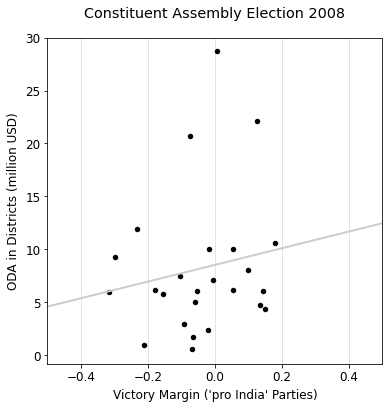

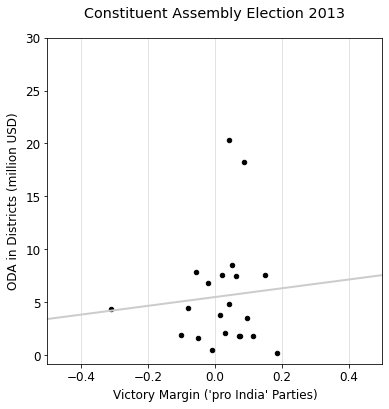

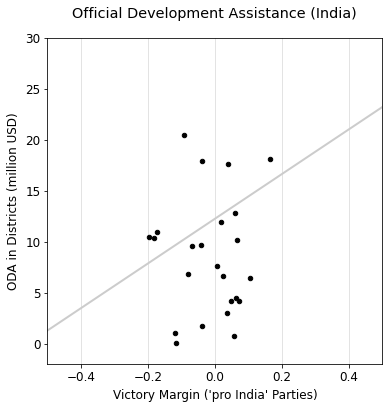

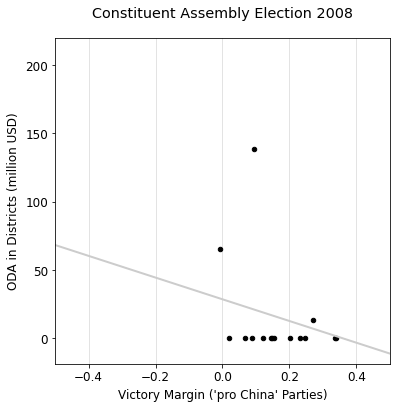

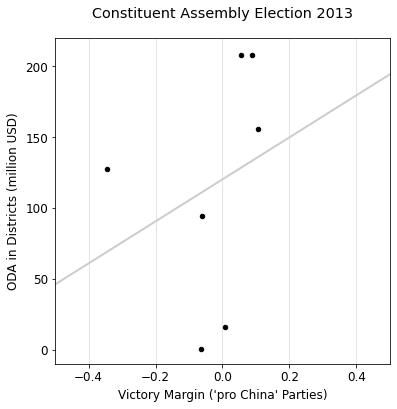

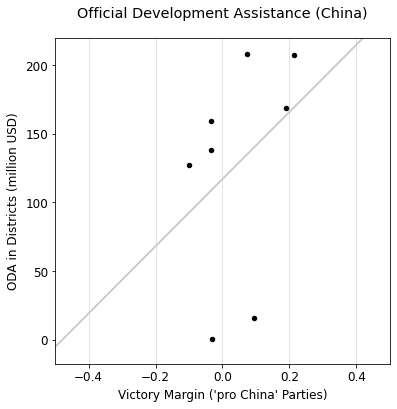

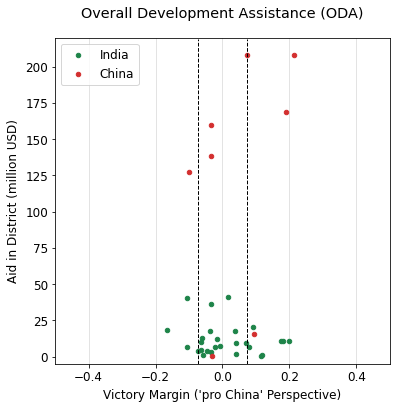

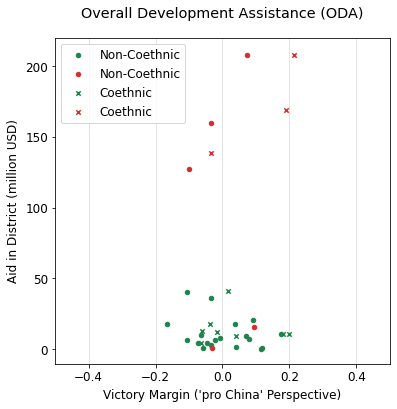

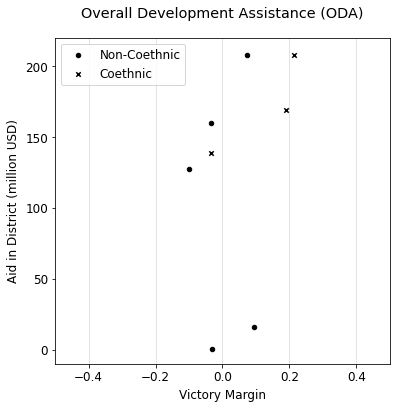

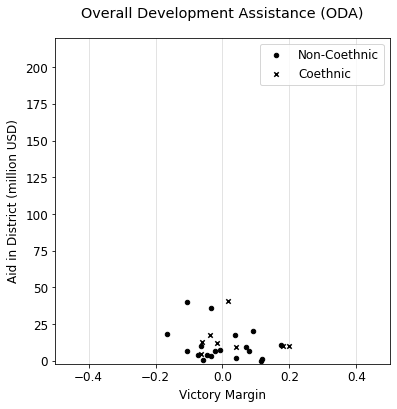

In [678]:
def get_axis(margin, amount):
    margin = get_distr_mean(margin, c_cum_vic).dropna()
    amount = get_distr_sum(amount, c_amount)
    joined = margin.join(amount).dropna()
    x = joined[c_cum_vic].to_numpy()
    y = joined[c_amount].to_numpy() / 1e6
    return x, y


# India First
x, y = get_axis(win_first, aid_first[aid_first[c_country] == v_india])
x, y = filter_out_below(x, y, 0.1)
x = -x
scatter_plot(
    x, y, 'victory_margin_india_2008', 
    title="Constituent Assembly Election 2008", 
    x_label='Victory Margin (\'pro India\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5,
    y_end=30,
    regression=True
)

# India Second
x, y = get_axis(win_second, aid_second[aid_second[c_country] == v_india])
x, y = filter_out_below(x, y, 0.1)
x = -x
scatter_plot(
    x, y, 'victory_margin_india_2013', 
    title="Constituent Assembly Election 2013", 
    x_label='Victory Margin (\'pro India\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5,
    y_end=30
)

# India Both
x, y = get_axis(win, aid_india)
x, y = filter_out_below(x, y, 0.1)
x = -x
scatter_plot(
    x, y, 'victory_margin_india_both', 
    title="Official Development Assistance (India)", 
    x_label='Victory Margin (\'pro India\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5,
    y_end=30,
    regression=True,
)

# China First
x, y = get_axis(win_first, aid_first[aid_first[c_country] == v_china])
scatter_plot(
    x, y, 'victory_margin_china_2008', 
    title="Constituent Assembly Election 2008", 
    x_label='Victory Margin (\'pro China\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220,
    regression=True
)

# China Second
x, y = get_axis(win_second, aid_second[aid_second[c_country] == v_china])
scatter_plot(
    x, y, 
    file_name='victory_margin_china_2013', 
    title="Constituent Assembly Election 2013", 
    x_label='Victory Margin (\'pro China\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220,
    regression=True
)

# China Both
x, y = get_axis(win, aid_china)
x, y = filter_out_below(x, y, 0.1)
scatter_plot(
    x, y, 'victory_margin_china_both', 
    title="Official Development Assistance (China)", 
    x_label='Victory Margin (\'pro China\' Parties)', 
    y_label="ODA in Districts (million USD)", 
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220,
    regression=True
)
 
# Combined 
x_china, y_china = get_axis(win, aid[aid[c_country] == v_china])
x_china, y_china = filter_out_below(x_china, y_china, 0.1)
x_india, y_india = get_axis(win, aid[aid[c_country] == v_india])
x_india, y_india = filter_out_below(x_india, y_india, 0.1)

scatter_plot_multi(
    [x_india, x_china], 
    [y_india, y_china], 
    file_name='victory_margin_combined', 
    title="Overall Development Assistance (ODA)", 
    x_label='Victory Margin (\'pro China\' Perspective)',
    y_label="Aid in District (million USD)", 
    labels=['India','China'], 
    colors=[green, red],
    markers=['o', 'o'],
    x_start=-0.5, 
    x_end=0.5, 
    y_start=-5,
    y_end=220, 
    labels_loc=2,
    grid_lines=[-0.074, 0.074],
)

# Combined with ethnicity
x_china_nm, y_china_nm = get_axis(win, aid_china[aid_china[c_ethn] != 'Tamang'])
x_china_nm, y_china_nm = filter_out_below(x_china_nm, y_china_nm, 0.1)

x_china_tamang, y_china_tamang = get_axis(win, aid_china[aid_china[c_ethn] == 'Tamang'])
x_china_tamang, y_china_tamang = filter_out_below(x_china_tamang, y_china_tamang, 0.1)

x_india_nm, y_india_nm = get_axis(win, aid_india[(aid_india[c_ethn] != 'Tharu') & (aid_india[c_ethn] != 'Yadav')])
x_india_nm, y_india_nm = filter_out_below(x_india_nm, y_india_nm, 0.1)

x_india_tharu_yadav, y_india_tharu_yadav = get_axis(win, aid_india[(aid_india[c_ethn] == 'Tharu') | (aid_india[c_ethn] == 'Yadav')])
x_india_tharu_yadav, y_india_tharu_yadav = filter_out_below(x_india_tharu_yadav, y_india_tharu_yadav, 0.1)

scatter_plot_multi(
    [x_india_nm, x_china_nm, x_india_tharu_yadav, x_china_tamang], 
    [y_india_nm, y_china_nm, y_india_tharu_yadav, y_china_tamang], 
    file_name='victory_margin_combined_ethnicity', 
    title="Overall Development Assistance (ODA)", 
    x_label='Victory Margin (\'pro China\' Perspective)',
    y_label="Aid in District (million USD)", 
    labels=['Non-Coethnic', 'Non-Coethnic', 'Coethnic', 'Coethnic'], 
    colors=[green, red, green, red], 
    markers=['o', 'o', 'x', 'x'],
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220, 
    labels_loc=2,
)

# China ethnicity
scatter_plot_multi(
    [x_china_nm, x_china_tamang], 
    [y_china_nm, y_china_tamang], 
    file_name='victory_margin_china_ethnicity', 
    title="Overall Development Assistance (ODA)", 
    x_label='Victory Margin',
    y_label="Aid in District (million USD)", 
    labels=['Non-Coethnic', 'Coethnic'], 
    colors=['black', 'black'], 
    markers=['o','x'],
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220, 
)

# India ethnicity
scatter_plot_multi(
    [x_india_nm, x_india_tharu_yadav], 
    [y_india_nm, y_india_tharu_yadav], 
    file_name='victory_margin_india_ethnicity', 
    title="Overall Development Assistance (ODA)", 
    x_label='Victory Margin',
    y_label="Aid in District (million USD)", 
    labels=['Non-Coethnic', 'Coethnic'], 
    colors=['black', 'black'], 
    markers=['o','x'],
    x_start=-0.5, 
    x_end=0.5, 
    y_end=220, 
)

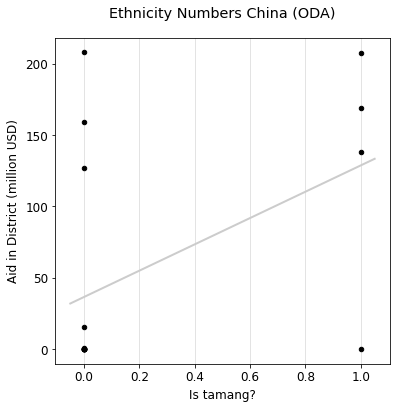

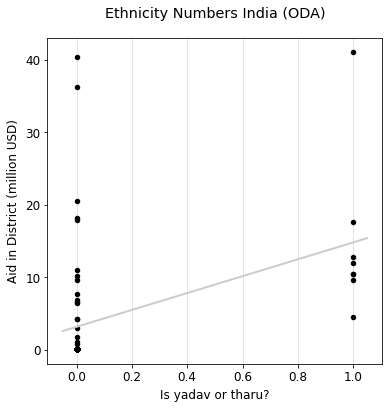

In [679]:
def get_axis(df, col):
    x_axis = get_distr_mean(df, col).dropna()
    amount = get_distr_sum(df, c_amount)
    joined = x_axis.join(amount).dropna()
    x = joined[col].to_numpy()
    y = joined[c_amount].to_numpy() / 1e6
    return filter_out_below(x, y, 0)

# China ethnicity with numbers

x_china, y_china = get_axis(aid_china, c_is_tamang)
scatter_plot(
    x_china, 
    y_china, 
    file_name='ethn_numbers_china', 
    title="Ethnicity Numbers China (ODA)", 
    x_label='Is tamang?',
    y_label="Aid in District (million USD)", 
)

x_india, y_india = get_axis(aid_india, c_is_yadav_tharu)
scatter_plot(
    x_india, 
    y_india, 
    file_name='ethn_numbers_india', 
    title="Ethnicity Numbers India (ODA)", 
    x_label='Is yadav or tharu?',
    y_label="Aid in District (million USD)", 
)

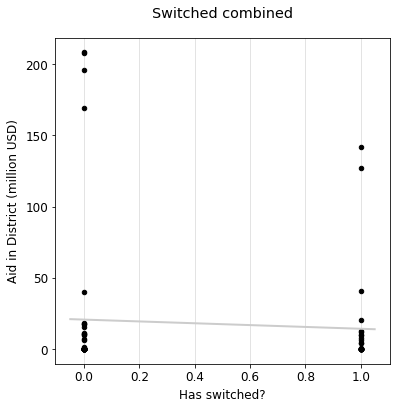

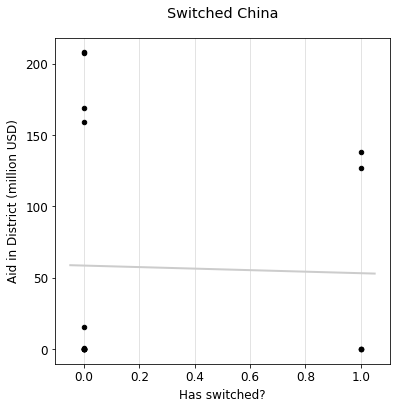

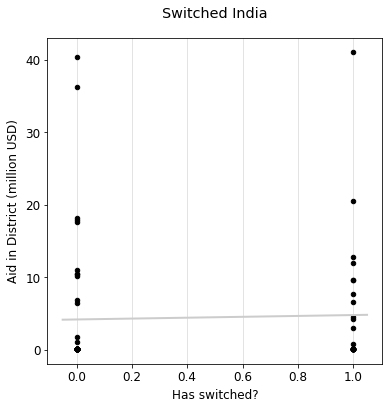

In [680]:
c_pro_china_first = 'pro china first'
c_pro_china_second = 'pro china second'
c_has_switched = 'has switched?'

def get_axis(win_merged, amount):
    has_switched = get_distr_mean(win_merged, c_has_switched)
    amount = get_distr_sum(amount, c_amount)
    joined = has_switched.join(amount).dropna()
    x = joined[c_has_switched].to_numpy()
    y = joined[c_amount].to_numpy() / 1e6
    return x, y


win_first_rel = win_first.dropna(subset=[c_cum_vic]).sort_values(by=['District'])
win_first_rel[c_pro_china_first] = (win_first_rel[c_cum_vic] > 0).astype(int)
win_first_rel = win_first_rel[[c_district, c_pro_china_first]]

win_second_rel = win_second.dropna(subset=[c_cum_vic]).sort_values(by=['District'])
win_second_rel[c_pro_china_second] = (win_second_rel[c_cum_vic] > 0).astype(int)
win_second_rel = win_second_rel[[c_district, c_pro_china_second]]
win_merged = win_first_rel.merge(win_second_rel, on=c_district)
win_merged[c_has_switched] = (win_merged[c_pro_china_first] != win_merged[c_pro_china_second]).astype(int)

# Combined swing theory
x_china, y_china = get_axis(win_merged, aid)
scatter_plot(
    x_china, 
    y_china, 
    file_name='swing_combined', 
    title="Switched combined", 
    x_label='Has switched?',
    y_label="Aid in District (million USD)", 
    regression=True
)

# China swing theroy 
x_china, y_china = get_axis(win_merged, aid_china)
scatter_plot(
    x_china, 
    y_china, 
    file_name='swing_china', 
    title="Switched China", 
    x_label='Has switched?',
    y_label="Aid in District (million USD)", 
    regression=True
)

# india swing theroy 
x_china, y_china = get_axis(win_merged, aid_india)
scatter_plot(
    x_china, 
    y_china, 
    file_name='swing_india', 
    title="Switched India", 
    x_label='Has switched?',
    y_label="Aid in District (million USD)", 
    regression=True
)


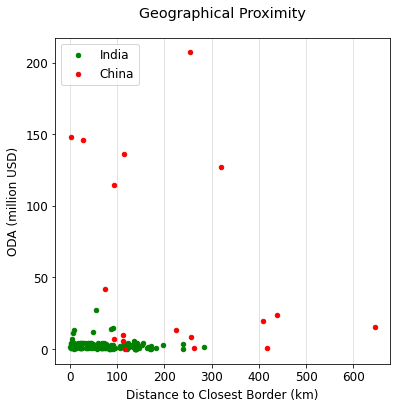

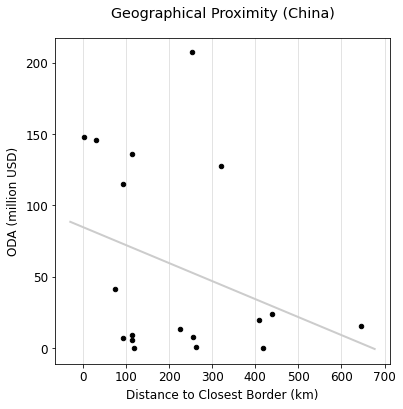

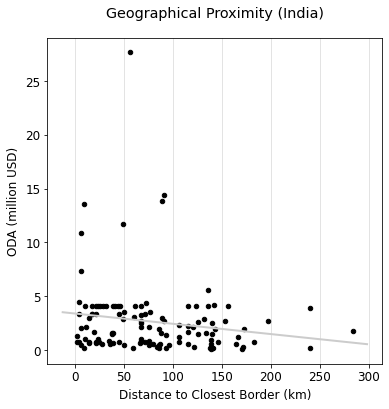

In [681]:
# Aid vs. Distance

def get_axis(df):
    distance = get_location_mean(df, c_distance).dropna()
    amount = get_location_sum(df, c_amount)
    joined = distance.join(amount).dropna()
    x = joined[c_distance].to_numpy()
    y = joined[c_amount].to_numpy() / 1e6
    return filter_out_below(x, y, 0.1)


x_china, y_china = get_axis(aid[aid[c_country] == v_china])
x_india, y_india = get_axis(aid[aid[c_country] == v_india])

# Combined
scatter_plot_multi(
    [x_india, x_china],
    [y_india, y_china],
    file_name='distance_combined',
    colors=['green', 'red'],
    title='Geographical Proximity',
    x_label='Distance to Closest Border (km)',
    y_label="ODA (million USD)", 
    labels=['India', 'China'],
    markers=['o', 'o'],
    labels_loc=2,
)

# China
scatter_plot(
    x_china, y_china, 
    file_name='distance_china',
    title="Geographical Proximity (China)", 
    x_label='Distance to Closest Border (km)', 
    y_label="ODA (million USD)",
    regression=True
)

# India
scatter_plot(
    x_india, y_india, 
    file_name='distance_india',
    title="Geographical Proximity (India)", 
    x_label='Distance to Closest Border (km)', 
    y_label="ODA (million USD)", 
    regression=True
)


In [682]:
# Control
def get_axis(df, x_col):
    x_stat = get_distr_mean(df, x_col).dropna()
    amount = get_distr_sum(df, c_amount)
    joined = x_stat.join(amount).dropna()
    x = joined[x_col].to_numpy()
    y = joined[c_amount].to_numpy() / 1e6
    return filter_out_below(x, y, 0.1)

def get_axis_pc(df, x_col):
    x_stat = get_distr_mean(df, x_col).dropna()
    amount = get_distr_sum(df, c_aid_pc)
    joined = x_stat.join(amount).dropna()
    x = joined[x_col].to_numpy()
    y = joined[c_aid_pc].to_numpy()
    return x, y

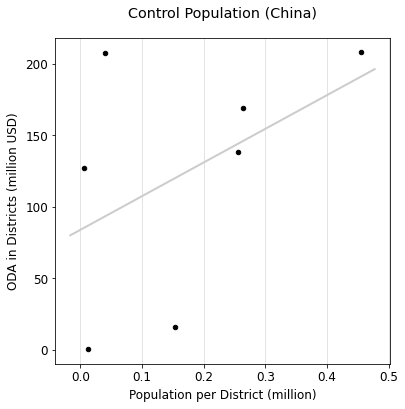

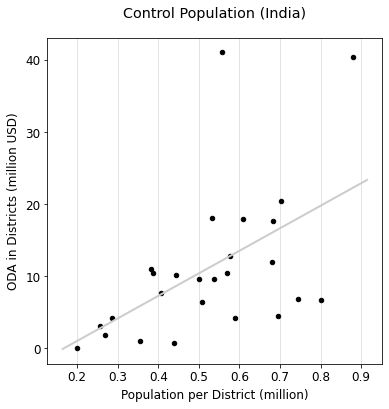

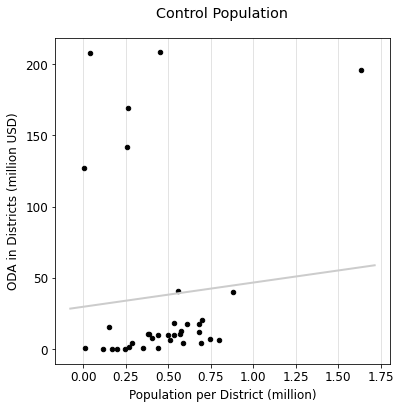

In [683]:
# Control Population
# China
x, y = get_axis(aid_china, c_population)
x /= 1e6
y, x = filter_out_above(y, x, 1.6)
scatter_plot(
    x, y, 
    file_name='control_population_china',
    title="Control Population (China)", 
    x_label='Population per District (million)', 
    y_label="ODA in Districts (million USD)", 
)

# India
x, y = get_axis(aid_india, c_population)
x /= 1e6
y, x = filter_out_above(y, x, 1.6)

scatter_plot(
    x, y, 
    file_name='control_population_india',
    title="Control Population (India)", 
    x_label='Population per District (million)', 
    y_label="ODA in Districts (million USD)", 
)

# Combined
x, y = get_axis(aid, c_population)
x /= 1e6
scatter_plot(
    x, y, 
    file_name='control_population_combined',
    title="Control Population", 
    x_label='Population per District (million)', 
    y_label="ODA in Districts (million USD)", 
)

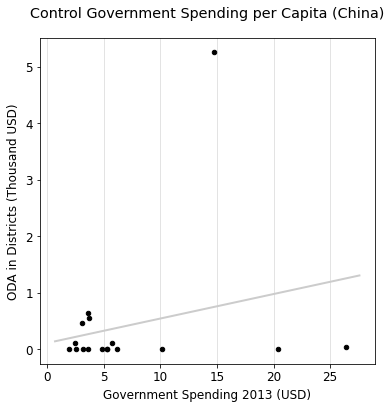

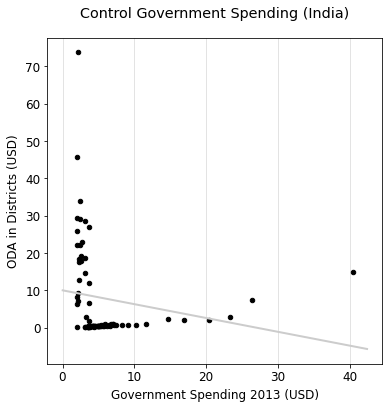

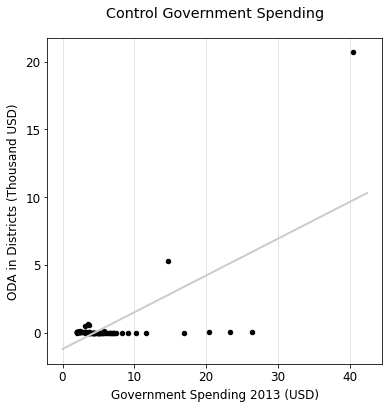

In [684]:
# Control Government Spending
# China
x, y = get_axis_pc(aid_china, c_gov_spend_pc)
y /= 1000
x, y = filter_out(x, y, x < 40)

scatter_plot(
    x, y, 
    file_name='control_gov_spend_pc_china',
    title="Control Government Spending per Capita (China)", 
    x_label='Government Spending 2013 (USD)', 
    y_label="ODA in Districts (Thousand USD)", 
)

# India
x, y = get_axis_pc(aid_india, c_gov_spend_pc)
scatter_plot(
    x, y, 
    file_name='control_gov_spend_pc_india',
    title="Control Government Spending (India)", 
    x_label='Government Spending 2013 (USD)', 
    y_label="ODA in Districts (USD)", 
)

# Combined
x, y = get_axis_pc(aid, c_gov_spend_pc)
y /= 1000
scatter_plot(
    x, y, 
    file_name='control_gov_spend_pc_combined',
    title="Control Government Spending", 
    x_label='Government Spending 2013 (USD)', 
    y_label="ODA in Districts (Thousand USD)", 
)



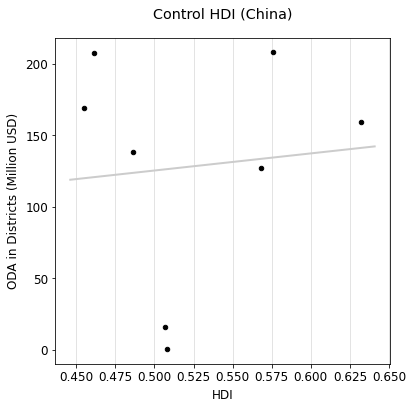

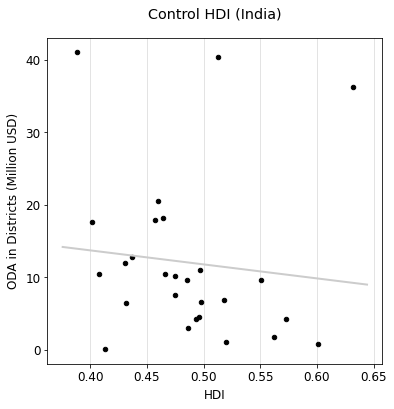

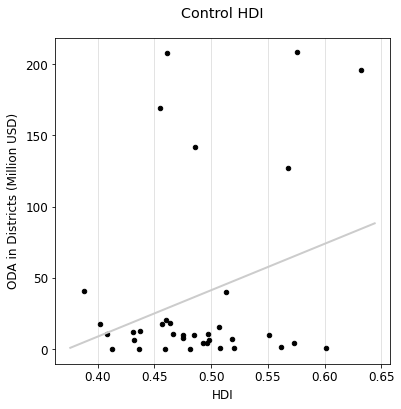

In [685]:
# Control HDI
# China
x, y = get_axis(aid_china, c_hdi)
scatter_plot(
    x, y, 
    file_name='control_hdi_china',
    title="Control HDI (China)", 
    x_label='HDI', 
    y_label="ODA in Districts (Million USD)", 
)

# India
x, y = get_axis(aid_india, c_hdi)
scatter_plot(
    x, y, 
    file_name='control_hdi_india',
    title="Control HDI (India)", 
    x_label='HDI', 
    y_label="ODA in Districts (Million USD)", 
)

# Combined
x, y = get_axis(aid, c_hdi)
scatter_plot(
    x, y, 
    file_name='control_hdi_combined',
    title="Control HDI", 
    x_label='HDI', 
    y_label="ODA in Districts (Million USD)", 
)

,title,R-value,R2-value,p-value


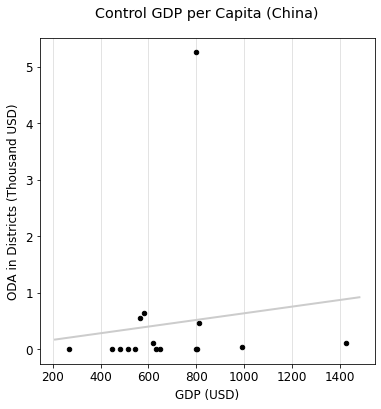

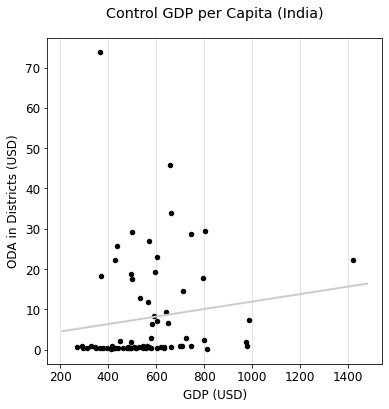

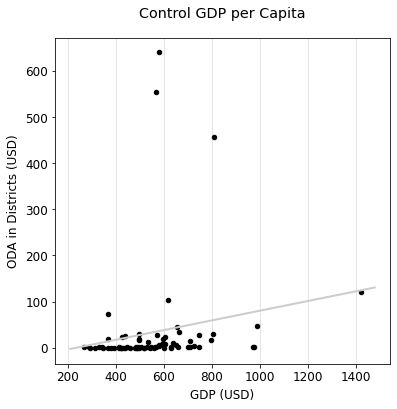

In [686]:
# Control GDP
# China
x, y = get_axis_pc(aid_china, c_gdp_usd_pc)
y /= 1000
x, y = filter_out(x, y, x < 1600)
scatter_plot(
    x, y, 
    file_name='control_gdp_pc_china',
    title="Control GDP per Capita (China)", 
    x_label='GDP (USD)', 
    y_label="ODA in Districts (Thousand USD)", 
)

# India
x, y = get_axis_pc(aid_india, c_gdp_usd_pc)
x, y = filter_out(x, y, x < 1600)
scatter_plot(
    x, y, 
    file_name='control_gdp_pc_india',
    title="Control GDP per Capita (India)", 
    x_label='GDP (USD)', 
    y_label="ODA in Districts (USD)", 
)

# Combined
x, y = get_axis_pc(aid, c_gdp_usd_pc)
x, y = filter_out(x, y, x < 2000)
x, y = filter_out(x, y, y < 1000)
scatter_plot(
    x, y, 
    file_name='control_gdp_pc_combined',
    title="Control GDP per Capita", 
    x_label='GDP (USD)', 
    y_label="ODA in Districts (USD)"
    
)
#R Squared

df_r_values
